## **Importing libraries and loading the data**

In [1]:
# General Libraries

import warnings
warnings.filterwarnings('ignore')

# Data Explotation libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #Visualization
%matplotlib inline
import seaborn as sns

# Data modelling libraries
from sklearn.impute import SimpleImputer
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, auc


import itertools
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

In [126]:
#loading the data
credit=pd.read_csv('/content/creditcard.csv')

In [127]:
credit.shape

(284807, 31)

In [ ]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

2. Basic EDA and Data Cleaning

In [128]:
#checking for the missingness of the data
#there are no missing values in the data
credit.isnull().sum().sort_values(ascending = False)

Time      0
V16       0
Amount    0
V28       0
V27       0
V26       0
V25       0
V24       0
V23       0
V22       0
V21       0
V20       0
V19       0
V18       0
V17       0
V15       0
V1        0
V14       0
V13       0
V12       0
V11       0
V10       0
V9        0
V8        0
V7        0
V6        0
V5        0
V4        0
V3        0
V2        0
Class     0
dtype: int64

## **Checking for class imbalance**

In [129]:
credit['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [130]:
 #checking for class imbalance with respect to the taraget variable'class'

print('No Frauds', round(credit['Class'].value_counts()[0]/len(credit) * 100,2), '% of the dataset')
print('Frauds', round(credit['Class'].value_counts()[1]/len(credit
) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


Text(0.5, 1, 'Class counts')

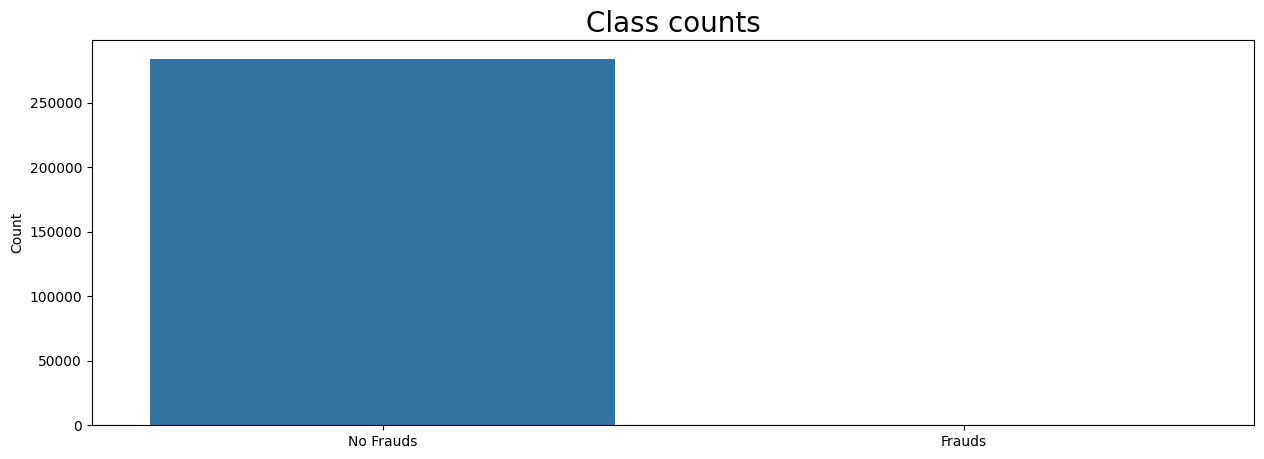

In [131]:
#The classes are heavily imabalanced we need to solve this issue later.
# Getting the number of positive and negative examples.
plt.figure(figsize=(15, 5))

# Countplot to visualize class distribution
sns.countplot(data=credit, x='Class')

# Set x-tick labels
plt.xticks(ticks=[0, 1], labels=['No Frauds', 'Frauds'])

plt.xlabel("")
plt.ylabel("Count")
plt.title("Class counts", y=1, fontdict={"fontsize": 20})

Most of the transactions are non-fraud (99.73 % of the dataset) as compared toto fraud(0.17 % of the dataset). If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud.

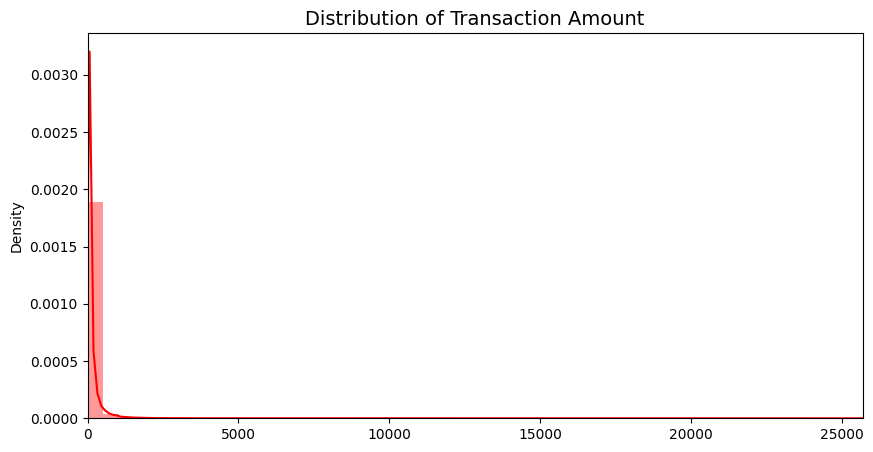

In [132]:
plt.figure( figsize=(10,5))

amount_val = credit['Amount'].values

sns.distplot(amount_val, color='r')
plt.title('Distribution of Transaction Amount', fontsize=14)
plt.xlim([min(amount_val), max(amount_val)])

plt.show()

The distribution of the transaction amount is skewed to the right. Now let's compare the transacted amount between the 'fraud' and 'non-fraud' groups.

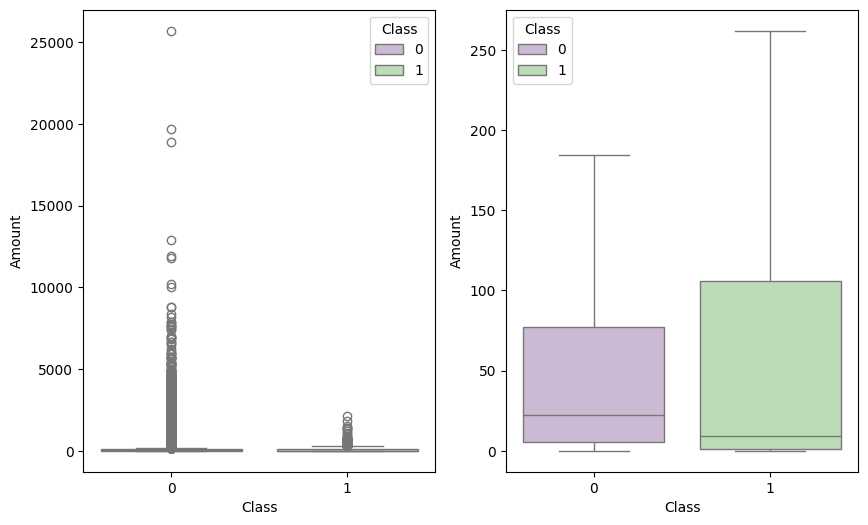

In [133]:
#comparing distribution of transaction amount between the non-fradulanet class(0.0), fradulent class(1.0)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=credit, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=credit, palette="PRGn",showfliers=False)
plt.show()

The non-fraud transactions have a larger mean value, larger Q1, smaller Q3 and max  and larger outliers; fraudulent transactions have a smaller Q1 and mean, larger max and smaller outliers.

(0.0, 172792.0)

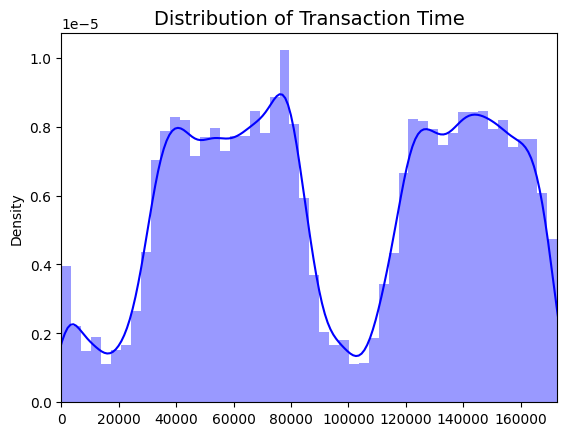

In [ ]:
#distribution of the time of transactions
time_val = credit['Time'].values
sns.distplot(time_val, color='b')
plt.title('Distribution of Transaction Time', fontsize=14)
plt.xlim([min(time_val), max(time_val)])

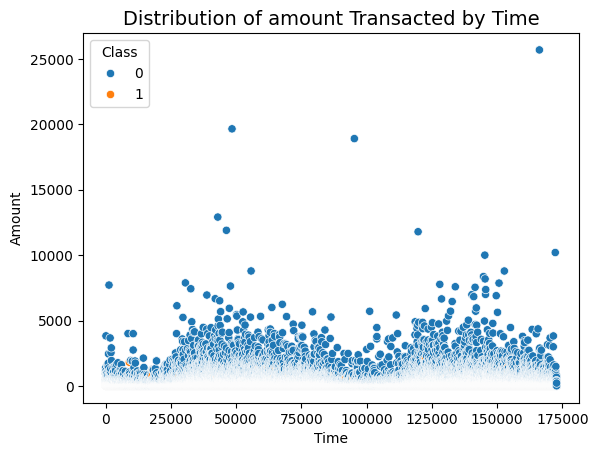

In [ ]:
#distribution of the time of transactions

sns.scatterplot(data=credit,x='Time', y='Amount',hue='Class', color='b')
plt.title('Distribution of amount Transacted by Time', fontsize=14)
plt.show()

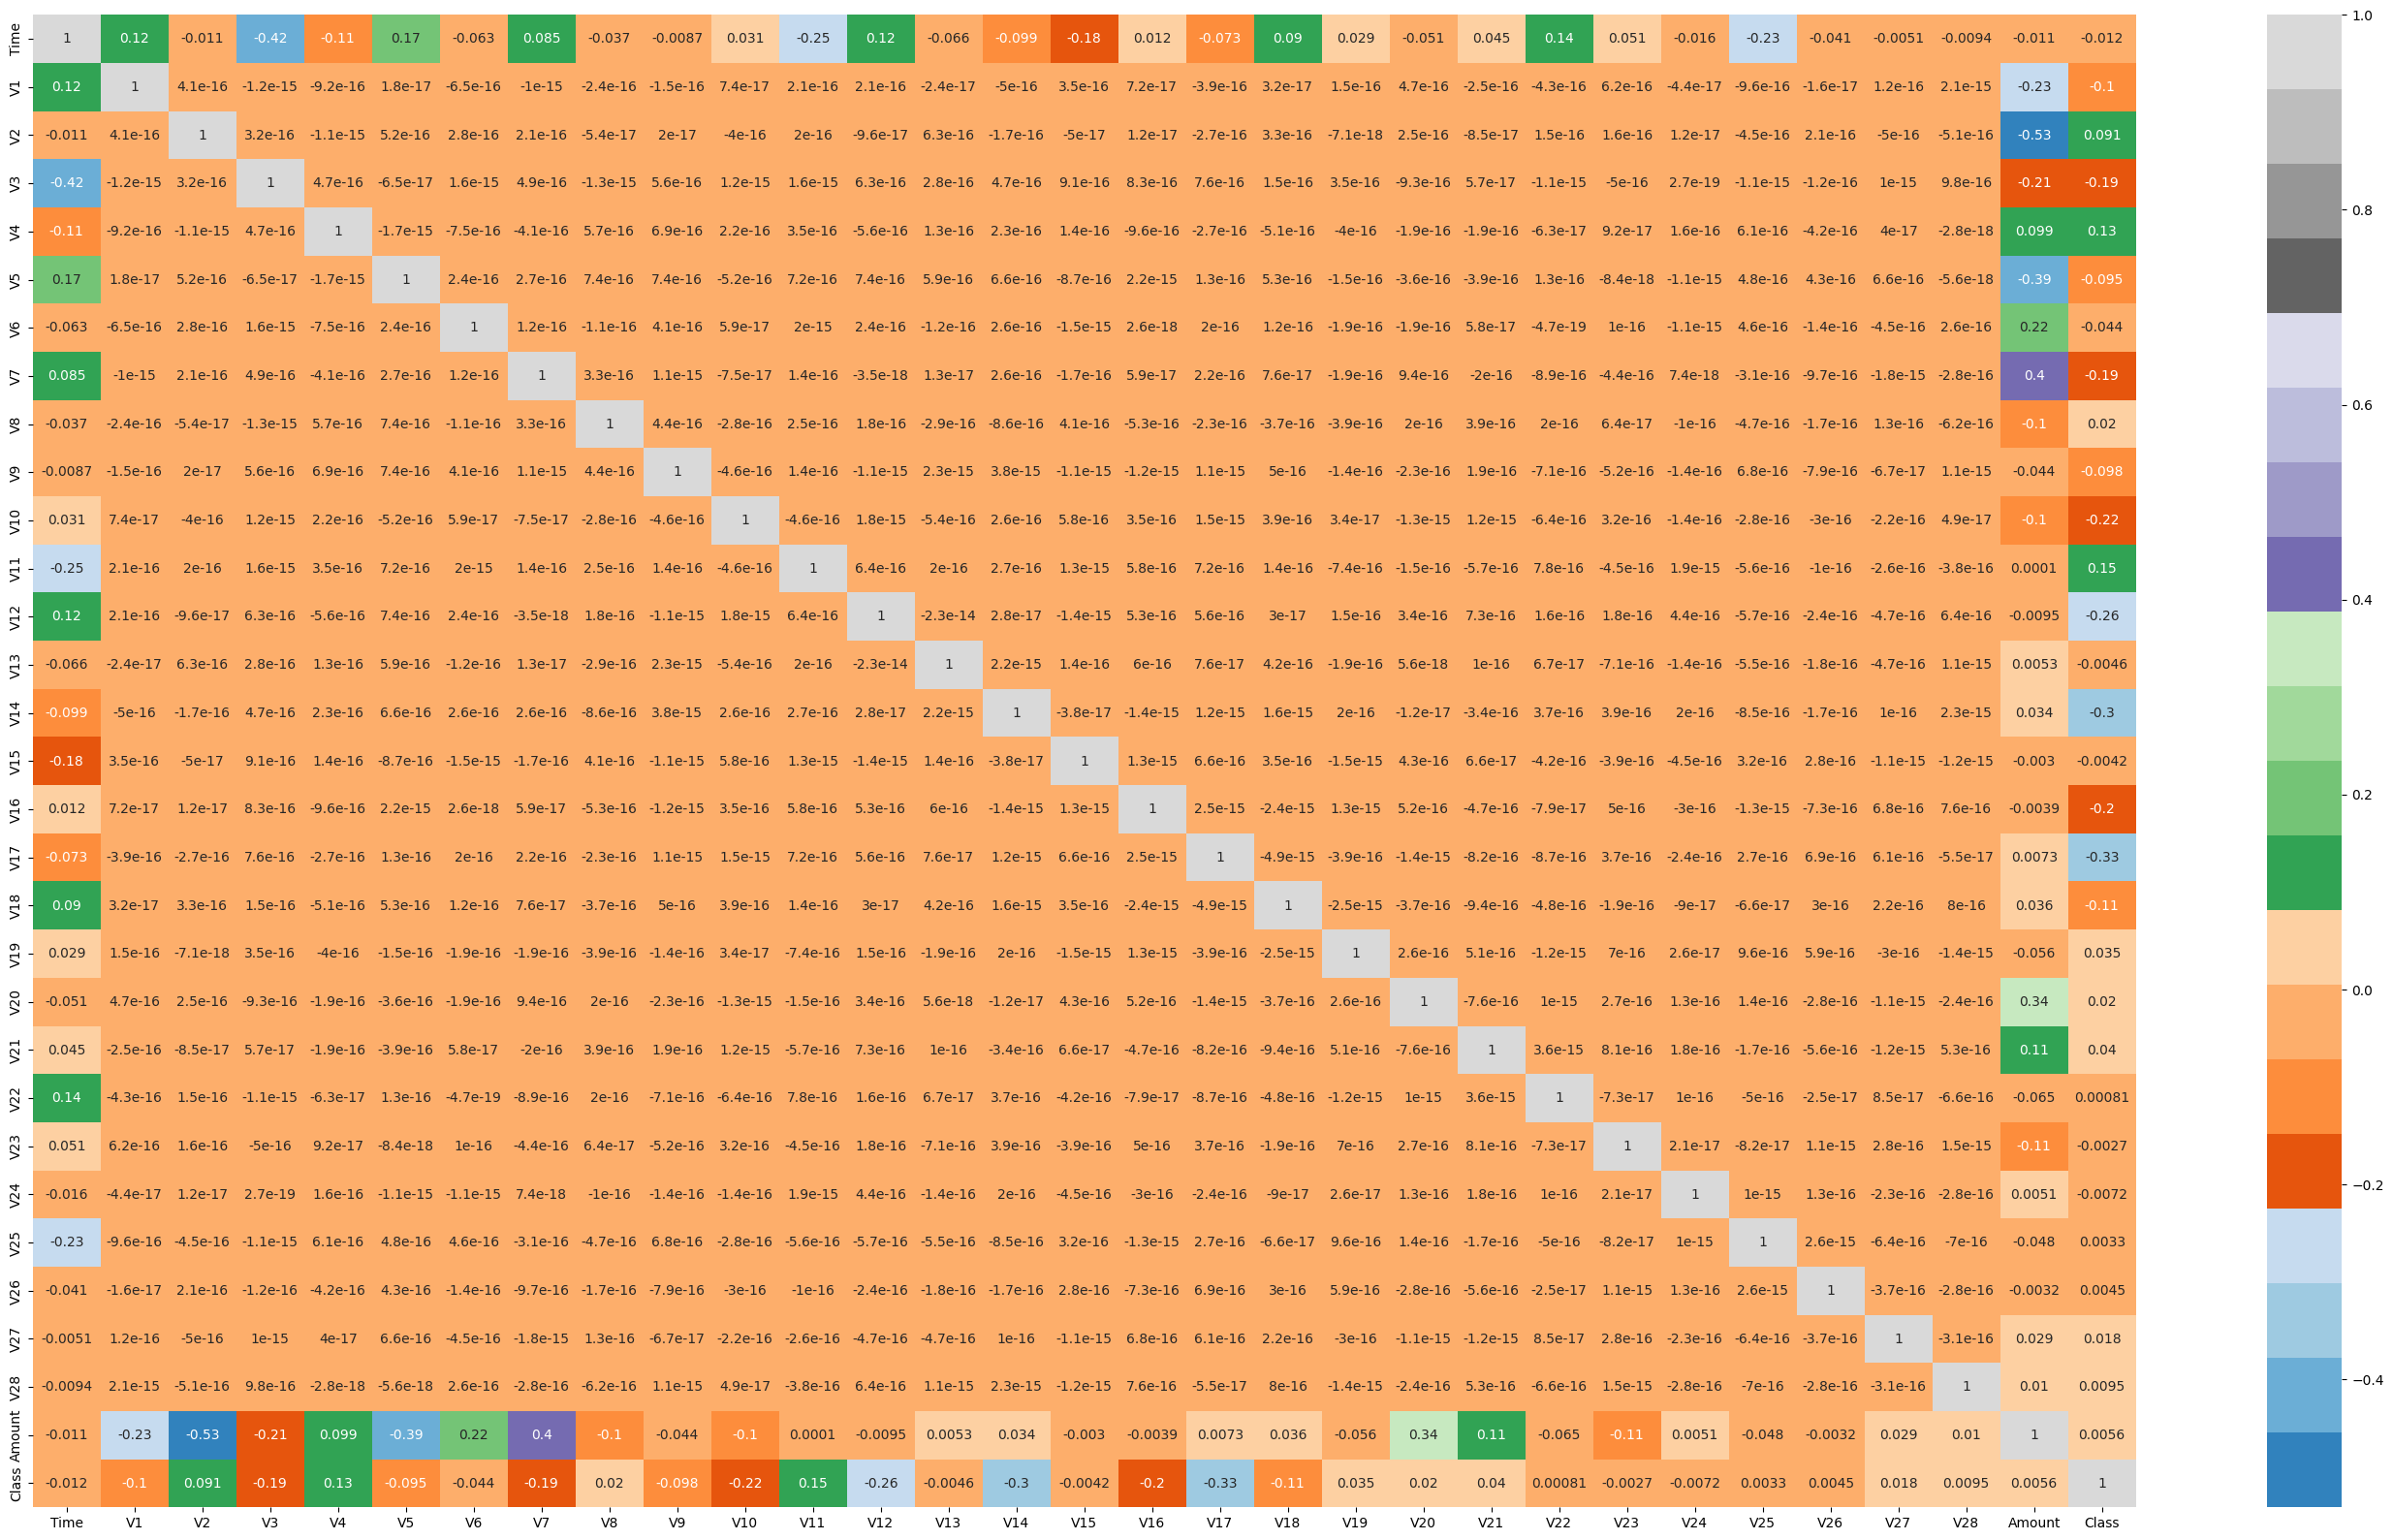

In [ ]:
#plotting the correlation matrix
plt.figure(figsize=(35,20))
sns.heatmap(credit.corr(),annot=True,cmap="tab20c")
plt.show()

From the correlation matrix we can see that:

Positive Correlation: Features V2, V4, V11 & V19 show positive correlation with class. The higher the values of these features, the higher the chances of a transaction being fraudulant.


Negative Correlation: Features V10, V12, V14 & V17 show negative correlation with class. The lower the values of these features, the higher the chances of a transaction being fraudulant.

# **Feature scaling**

Since the time and amount features have outliers a robust scaler can handle this outliers effectively

In [134]:
##We don't know what the other features are, but they are scaled, so we are only going to scale the Time and Amount features
# Feature Scaling
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
credit['Time'] = scaler.fit_transform(credit['Time'].values.reshape(-1, 1))
credit['Amount'] = scaler.fit_transform(credit['Amount'].values.reshape(-1, 1))

## separating the X and the Y values

In [135]:
#making a copy of the data
data=credit.copy()

In [137]:
#separating the X and the Y values
X = data.drop(['Class'], axis = 1)
y= data["Class"]
print(X.shape)
print(y.shape)

(284807, 30)
(284807,)


# **Modelling with the unbalanced data**

In [138]:
# getting just the values for the sake of processing
xData = X.values
yData = y.values
#split the data into training and testing sets
xtrain, xtest, ytrain, ytest = train_test_split(xData, yData, test_size = 0.2, random_state = 42)

              precision    recall  f1-score   support

   Non-fraud       1.00      1.00      1.00     56864
       Fraud       0.86      0.58      0.70        98

    accuracy                           1.00     56962
   macro avg       0.93      0.79      0.85     56962
weighted avg       1.00      1.00      1.00     56962



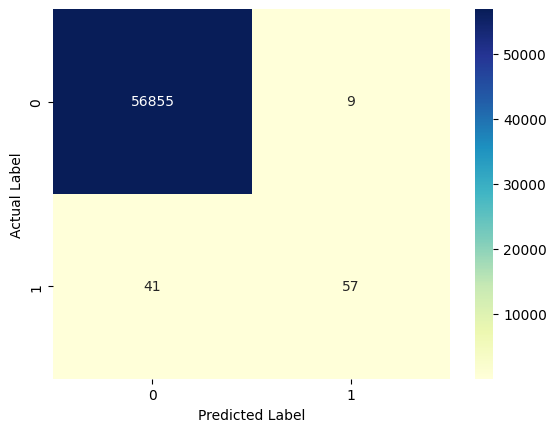

In [148]:

logreg = LogisticRegression()
logreg.fit(xtrain, ytrain)
y_pred = logreg.predict(xtest)
cnf_matrix = confusion_matrix(ytest, y_pred)

#evaluating the performance of a classification model
from sklearn.metrics import confusion_matrix, classification_report

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')


labels = ['Non-fraud', 'Fraud']
print(classification_report(ytest, y_pred, target_names=labels))

As we can see this is not a good model, because it is biased towards majority class and the recall in minority class is not as high as disired. Therefore, it would be wise to balance the data before modelling.

# **Oversampling and undersampling techniques**

Earlier we saw that the dataset was high imbalanced. Most of the transactions are non-fraud (99.73 % of the dataset) as compared to the fraud(0.17 % of the dataset). So the algorithms are much more likely to classify new observations to the majority class and high accuracy won't tell us anything. To address the problem of imbalanced dataset we can use undersampling and oversampling data approach techniques. Oversampling increases the number of minority class members in the training set. The advantage of oversampling is that no information from the original training set is lost unlike in undersampling, as all observations from the minority and majority classes are kept. On the other hand, it is prone to overfitting. There is a type of oversampling called SMOTE (Synthetic Minority Oversampling Technique), which we are going to use to make our dataset balanced. It creates synthetic points from the minority class

<Axes: >

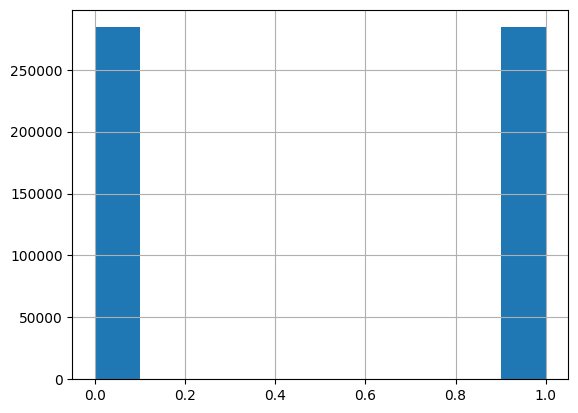

In [145]:
smote_sample=SMOTE(random_state=124,sampling_strategy='auto') # the sampling strategy can be one of float, str, dict or callable `float``,
#it corresponds to the desired ratio of the number of samples in the minority class over the number of samples in the majority class after resampling ie {1:500}
# ``'minority'``: resample only  minority class; 'not minority'``:all but the minority class; ``'not majority'``: all but the majority, ``'all'`` ,``'auto'``:
x_res, y_res=smote_sample.fit_resample(X,y)


# now plot the classes
y_res.hist()

# **Data Modelling**

In [146]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x_res, y_res, test_size=0.2, random_state=42)

In [ ]:
 len(y_test) == len(y_pred),

In [150]:
# Define hyperparameters grid for logistic regression
param_grid_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

# Initialize logistic regression classifier
lr_classifier = LogisticRegression()

# Grid search with cross-validation
grid_search_lr = GridSearchCV(estimator=lr_classifier, param_grid=param_grid_lr, cv=5, scoring='roc_auc')
grid_search_lr.fit(X_train, y_train)

# Best parameters and best score
print("Logistic Regression - Best Parameters:", grid_search_lr.best_params_)
print("Logistic Regression - Best ROC AUC Score:", grid_search_lr.best_score_)

# Predict on the testing set with the best model
best_lr_classifier = grid_search_lr.best_estimator_
y_pred_lr = best_lr_classifier.predict(X_test)

# Evaluate the model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print("Logistic Regression - Accuracy:", accuracy_lr)
print("Logistic Regression - Precision:", precision_lr)
print("Logistic Regression - Recall:", recall_lr)
print("Logistic Regression - F1 Score:", f1_lr)


Logistic Regression - Best Parameters: {'C': 10, 'penalty': 'l2'}
Logistic Regression - Best ROC AUC Score: 0.9893715327154162
Logistic Regression - Accuracy: 0.949589363909748
Logistic Regression - Precision: 0.9751497505702575
Logistic Regression - Recall: 0.9228973602920528
Logistic Regression - F1 Score: 0.9483043129333898


Recall of fraud cases (sensitivity) summarizes true positive rate (True positive/True positive + False Negative) - how many cases we got correct out of all the positive ones

Recall of non-fraud (specificity) summarizes true negative rate (True negative/True negative + False positive) - how many cases we got correct out of all the negative ones

Precision of fraud cases (True positive/True positive + False positive) summarizes the accuracy of fraud cases detected - out of all predicted as fraud, how many are correct

Precision of non-fraud cases (True negative/True negative + False negative) summarizes the accuracy of non-fraud cases detected - out of all predicted as non-fraud, how many are correct
F1-score is the harmonic mean of recall and precision

Unlike with the previously unballanced data now we got a high recall which means our model is able to detect the highest number of fraud transactions. We can improve the precision, which we are going to try to achieve with Random Forest

In [ ]:
# Define hyperparameters grid for random forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize random forest classifier
rf_classifier = RandomForestClassifier()

# Grid search with cross-validation
grid_search_rf = GridSearchCV(estimator=rf_classifier, param_grid=param_grid_rf, cv=5, scoring='roc_auc')
grid_search_rf.fit(X_train, y_train)

# Best parameters and best score
print("Random Forest - Best Parameters:", grid_search_rf.best_params_)
print("Random Forest - Best ROC AUC Score:", grid_search_rf.best_score_)

# Predict on the testing set with the best model
best_rf_classifier = grid_search_rf.best_estimator_
y_pred_rf = best_rf_classifier.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred)
auprc = auc(recall_curve, precision_curve)

print("Random Forest - Accuracy:", accuracy_rf)
print("Random Forest - Precision:", precision_rf)
print("Random Forest - Recall:", recall_rf)
print("Random Forest - F1 Score:", f1_rf)
print("Random Forest - ROC AUC Score:", auprc)

Random forest had a higher precision as compared to the logistic regression model, however it has a slightly lower recall.